# Best Place to live in New Jersey - A 2020 Analysis  
##### By Kaival Panchal

Based on:
1. House Price
2. Nearby Venues
3. Population/Density

Data Sets:
1. https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/?refine.state=NJ
2. https://www.state.nj.us/treasury/taxation/lpt/class2avgsales.shtml
3. https://en.wikipedia.org/wiki/List_of_counties_in_New_Jersey
4. Foursquare API 

Goals: 
1. Data Preprocessing
2. Visualize Data Sets to get a feel of what we are working on
2. EDA, Visualize Average Sale price by County 
3. Load Nearby Venues by each county? or town? 
3. Compare House price to number of nearby venues, create a metric
    1. Want to see if a higher house price justifies lots of things to do
    2. Where can I buy a house for cheap and have a lot of things to do based on :
        1. House Price
        2. Nearby Venues
        3. Population/Density







#### Importing Important Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import folium 
import requests # to load webpages
from bs4 import BeautifulSoup as bs
import scipy

# 1.  Data Preprocessing

###  a. Loading geographical data into a Pandas dataframe

In [2]:
NJ_geodata = pd.read_csv('NJ_Data.csv', delimiter = ';', dtype = {'Zip': object})
NJ_geodata = NJ_geodata.drop(['Timezone', 'Daylight savings time flag'], axis = 1)
NJ_geodata.head()
print(len(NJ_geodata))
#Notes: 
# 1. delimiter was added as a result of analysis of the raw data, items were separated using a semicolon instead of comma.
# 2. dtype was changed to object because the 0 in Zip was being removed as a result of reading. 
# 3. Unnessecary Columns were removed

762


In [3]:
NJ_geodata.head() #displaying the first 5 rows to see how the data looks like

,Zip,City,State,Latitude,Longitude,geopoint
0,07747,Matawan,NJ,40.411102,-74.237670,"40.411102,-74.23767"
1,08867,Pittstown,NJ,40.583035,-74.962240,"40.583035,-74.96224"
2,07803,Mine Hill,NJ,40.878785,-74.600980,"40.878785,-74.60098"
3,08527,Jackson,NJ,40.115970,-74.322510,"40.11597,-74.32251"
4,08250,Tuckahoe,NJ,39.056521,-74.816619,"39.056521,-74.816619"


In [4]:
NJ_geodata = NJ_geodata.drop_duplicates(subset='City', keep="last")
NJ_geodata

,Zip,City,State,Latitude,Longitude,geopoint
0,07747,Matawan,NJ,40.411102,-74.237670,"40.411102,-74.23767"
1,08867,Pittstown,NJ,40.583035,-74.962240,"40.583035,-74.96224"
2,07803,Mine Hill,NJ,40.878785,-74.600980,"40.878785,-74.60098"
3,08527,Jackson,NJ,40.115970,-74.322510,"40.11597,-74.32251"
4,08250,Tuckahoe,NJ,39.056521,-74.816619,"39.056521,-74.816619"
...,...,...,...,...,...,...
756,08079,Salem,NJ,39.549912,-75.439430,"39.549912,-75.43943"
758,08620,Trenton,NJ,40.172960,-74.669150,"40.17296,-74.66915"
759,07208,Elizabeth,NJ,40.673102,-74.228340,"40.673102,-74.22834"
760,07670,Tenafly,NJ,40.921690,-73.964820,"40.92169,-73.96482"


##### Check to See if Any Null Values

In [5]:
missing = NJ_geodata.isnull().sum() # find the total null values within each category 
print(missing)
print('The length of the total dataset is: '+ str(len(NJ_geodata)))#see what the total dataset consists off 

Zip          0
City         0
State        0
Latitude     0
Longitude    0
geopoint     0
dtype: int64
The length of the total dataset is: 590


#### Visualize data set using Folium to check accuracy on a map 

In [6]:
# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, Zip, City in zip(NJ_geodata['Latitude'], NJ_geodata['Longitude'], NJ_geodata['City'], NJ_geodata['Zip']):
    label = '{}, {}'.format(Zip, City )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ    

### b. Loading Residential Sales data into a Pandas dataframe

In [7]:
NJ_Price = pd.read_excel('NJSalesPrice2020.xlsx')
NJ_Price.head(55)
# Notes:
# 1. Price Data is broken down by town and each Nan Values separates each County, 
# need to find a list of counties, and assign a county code to each town ie. bergen = 2- done
# 2. Remove remarks like City, Boro, TWP being careful not to remove City from like Atlantic City-Done
# 3. Remove Null Values -Done
# 3. Webscrape from Wiki Site to get Counties Info, Get County Name, Fips Code, Density/Mi^2, Pop and Area- Done
# 3. Merge geodata, Price, and counties data together


,CITY,# of Sales,Avg Sale Price
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,ABSECON CITY,107.0,1.863140e+05
3,ATLANTIC CITY CITY,164.0,1.178953e+05
4,BRIGANTINE CITY,408.0,3.664606e+05
5,BUENA BORO,42.0,1.563271e+05
6,BUENA VISTA TWP,48.0,1.840781e+05
7,CORBIN CITY CITY,4.0,2.700000e+05
8,EGG HARBOR CITY,52.0,1.377362e+05
9,EGG HARBOR TWP,545.0,2.265726e+05


#### Removing Null Values from NJ_Price 

In [8]:
missing = NJ_Price.isnull().sum() # find the total null values within each category 
print(missing)
print('The length of the total dataset is: '+ str(len(NJ_Price)))#see what the total dataset consists off 
NJ_Price = NJ_Price.dropna(axis=0) #utilize the function df.dropna, and specify that we would like to drop the empty rows
missing = NJ_Price.isnull().sum() #sum up all missing values to see if all null values were removed
print(missing)
print("The length of the data set after cleaning Null values is: " + str(len(NJ_Price)))# check

CITY              22
# of Sales        22
Avg Sale Price    22
dtype: int64
The length of the total dataset is: 607
CITY              0
# of Sales        0
Avg Sale Price    0
dtype: int64
The length of the data set after cleaning Null values is: 585


In [9]:
NJ_Price

,CITY,# of Sales,Avg Sale Price
2,ABSECON CITY,107.0,186314.0374
3,ATLANTIC CITY CITY,164.0,117895.3232
4,BRIGANTINE CITY,408.0,366460.6029
5,BUENA BORO,42.0,156327.0952
6,BUENA VISTA TWP,48.0,184078.1250
...,...,...,...
602,PHILLIPSBURG TOWN,110.0,124587.3182
603,POHATCONG TWP,22.0,238513.6364
604,WASHINGTON BORO,60.0,179278.4167
605,WASHINGTON TWP,68.0,283062.7941


### c. Webscrape Wikipedia data to get County Information


In [10]:
link = "https://en.wikipedia.org/wiki/List_of_counties_in_New_Jersey"

r = requests.get(link) # loading the webpage content
webpage = bs(r.content) # # Convert to a Beautiful Soup object, collects the HTML from the above website

In [11]:
table = webpage.find("table",{"class":"wikitable sortable"})
table_rows = table.find('tbody').find_all('tr')
l=[]
for tr in table_rows:
    td = tr.find_all('td') 
    row = [str(tr.get_text()).strip() for tr in td]
    l.append(row)    
    
Counties = ['none','Atlantic','Bergen','Burlington','Camden','CapeMay','Cumberland','Essex','Gloucester','Hudson','Hunterdon',
            'Mercer','Middlesex','Monmouth','Morris','Ocean','Passaic','Salem','Somerset','Sussex','Union','Warren']
NJ_County = pd.DataFrame(l)
NJ_County.insert(loc = 0,column = 'A', value = Counties)  

NJ_County.columns = ['County','FIPS Code', 'County Seat', 'Largest City','Est','Formed From','Named For','Density',
              'Population','Area','map']
NJ_County = NJ_County.drop(['County Seat', 'Largest City','Est','Formed From','Named For','map'], axis = 1) 

NJ_County = NJ_County.dropna(axis=0) 






In [12]:

NJ_County['Density'] = NJ_County['Density'].str.replace(',','').astype('float')
NJ_County['Population'] = NJ_County['Population'].str.replace(',','').astype('float')
NJ_County


,County,FIPS Code,Density,Population,Area
1,Atlantic,001,489.39,263670.0,"561 sq mi(1,453 km2)"
2,Bergen,003,3868.02,932202.0,234 sq mi(606 km2)
3,Burlington,005,557.43,445349.0,"805 sq mi(2,085 km2)"
4,Camden,007,2313.77,506471.0,222 sq mi(575 km2)
5,CapeMay,009,381.43,92039.0,255 sq mi(660 km2)
6,Cumberland,011,320.85,149527.0,"489 sq mi(1,267 km2)"
7,Essex,013,6221.98,798975.0,126 sq mi(326 km2)
8,Gloucester,015,887.04,291636.0,325 sq mi(842 km2)
9,Hudson,017,13495.02,672391.0,47 sq mi(122 km2)
10,Hunterdon,019,298.49,124371.0,"430 sq mi(1,114 km2)"


In [13]:
NJ_County['Area'] = NJ_County['Area'].astype('str')


NJ_County['AreaClean'] = NJ_County['Area'].str[0:3].astype('int')
NJ_County

,County,FIPS Code,Density,Population,Area,AreaClean
1,Atlantic,001,489.39,263670.0,"561 sq mi(1,453 km2)",561
2,Bergen,003,3868.02,932202.0,234 sq mi(606 km2),234
3,Burlington,005,557.43,445349.0,"805 sq mi(2,085 km2)",805
4,Camden,007,2313.77,506471.0,222 sq mi(575 km2),222
5,CapeMay,009,381.43,92039.0,255 sq mi(660 km2),255
6,Cumberland,011,320.85,149527.0,"489 sq mi(1,267 km2)",489
7,Essex,013,6221.98,798975.0,126 sq mi(326 km2),126
8,Gloucester,015,887.04,291636.0,325 sq mi(842 km2),325
9,Hudson,017,13495.02,672391.0,47 sq mi(122 km2),47
10,Hunterdon,019,298.49,124371.0,"430 sq mi(1,114 km2)",430


In [14]:
NJ_Price.head(30)

,CITY,# of Sales,Avg Sale Price
2,ABSECON CITY,107.0,1.863140e+05
3,ATLANTIC CITY CITY,164.0,1.178953e+05
4,BRIGANTINE CITY,408.0,3.664606e+05
5,BUENA BORO,42.0,1.563271e+05
6,BUENA VISTA TWP,48.0,1.840781e+05
7,CORBIN CITY CITY,4.0,2.700000e+05
8,EGG HARBOR CITY,52.0,1.377362e+05
9,EGG HARBOR TWP,545.0,2.265726e+05
10,ESTELL MANOR CITY,8.0,2.233000e+05
11,FOLSOM BORO,11.0,1.855091e+05


### d. Adding Dummy Variable to prepare for Splitting Algorithm 

In [15]:
NJ_Price['Dummy'] = 0 # setting a new column in NJ_Price to 0
NJ_Price['Dummy'] = np.where(NJ_Price['CITY'] != 'County Total', 0, 1) # Putting 1 in when the column value = county total
NJ_Price.head(50)

,CITY,# of Sales,Avg Sale Price,Dummy
2,ABSECON CITY,107.0,1.863140e+05,0
3,ATLANTIC CITY CITY,164.0,1.178953e+05,0
4,BRIGANTINE CITY,408.0,3.664606e+05,0
5,BUENA BORO,42.0,1.563271e+05,0
6,BUENA VISTA TWP,48.0,1.840781e+05,0
7,CORBIN CITY CITY,4.0,2.700000e+05,0
8,EGG HARBOR CITY,52.0,1.377362e+05,0
9,EGG HARBOR TWP,545.0,2.265726e+05,0
10,ESTELL MANOR CITY,8.0,2.233000e+05,0
11,FOLSOM BORO,11.0,1.855091e+05,0


### e. Algorithm to add County Names to NJ_Price from NJ_County 

In [16]:
# getting county code and county from NJ_County based on City in NJ_Price

i = 1 # starting at the first county index
Last_County = 21 # ending at the last county index
FIPS_Code= [] # empty list for code to be appended based on conditions
County_Name= [] # empty list for county name to be appended based on conditions

if i != Last_County: # iterate until the first county index does not equal last index
    for dummy in NJ_Price['Dummy']: #iterate through the dummy column in NJ Price
        if dummy == 0:
            code = NJ_County['FIPS Code'][i]
            county = NJ_County['County'] [i]
            County_Name.append(county)
            FIPS_Code.append(code) # if dummy is 0, print the Fips Code and county name for that specific county index i 
        elif i == Last_County:
            continue
        else:
            FIPS_Code.append('Not Valid')
            County_Name.append('Not Valid')# if dummy is 1, print 'Not Valid' for that specific county index i 
            i = i + 1 # move on to next county 
        
NJ_Price['FIPS Code'] = FIPS_Code # adding data to data frame
NJ_Price['County'] = County_Name # adding data to data frame
NJ_Price = NJ_Price.reset_index()
#
NJ_Price.head(55)
    

,index,CITY,# of Sales,Avg Sale Price,Dummy,FIPS Code,County
0,2,ABSECON CITY,107.0,1.863140e+05,0,001,Atlantic
1,3,ATLANTIC CITY CITY,164.0,1.178953e+05,0,001,Atlantic
2,4,BRIGANTINE CITY,408.0,3.664606e+05,0,001,Atlantic
3,5,BUENA BORO,42.0,1.563271e+05,0,001,Atlantic
4,6,BUENA VISTA TWP,48.0,1.840781e+05,0,001,Atlantic
5,7,CORBIN CITY CITY,4.0,2.700000e+05,0,001,Atlantic
6,8,EGG HARBOR CITY,52.0,1.377362e+05,0,001,Atlantic
7,9,EGG HARBOR TWP,545.0,2.265726e+05,0,001,Atlantic
8,10,ESTELL MANOR CITY,8.0,2.233000e+05,0,001,Atlantic
9,11,FOLSOM BORO,11.0,1.855091e+05,0,001,Atlantic


### f. Remove Duplicate Cities and Change to Lowercase except first letter of each word

In [17]:
# 2. Remove remarks like City, Boro, TWP being careful not to remove City from like Atlantic City
#NJ_Price['CITY'] = NJ_Price['CITY'].str.replace('BORO', '')# removing the word Boro
#NJ_Price['CITY'] = NJ_Price['CITY'].str.replace('TWP', '') # removing the word twp
#NJ_Price['CITY'] = NJ_Price['CITY'].str.replace('TOWN', '') #removing the word town

# above done in cleaning function below

NJ_Price['CITY'] = NJ_Price['CITY'].str.replace(r'\b(\w+)(\s+\1)+\b',r'\1') # replaces duplicate cities
NJ_Price['CITY'] = NJ_Price['CITY'].str.title() #converts All uppercase to lowercase except first letter of each word

NJ_Price.head(50)



,index,CITY,# of Sales,Avg Sale Price,Dummy,FIPS Code,County
0,2,Absecon City,107.0,1.863140e+05,0,001,Atlantic
1,3,Atlantic City,164.0,1.178953e+05,0,001,Atlantic
2,4,Brigantine City,408.0,3.664606e+05,0,001,Atlantic
3,5,Buena Boro,42.0,1.563271e+05,0,001,Atlantic
4,6,Buena Vista Twp,48.0,1.840781e+05,0,001,Atlantic
5,7,Corbin City,4.0,2.700000e+05,0,001,Atlantic
6,8,Egg Harbor City,52.0,1.377362e+05,0,001,Atlantic
7,9,Egg Harbor Twp,545.0,2.265726e+05,0,001,Atlantic
8,10,Estell Manor City,8.0,2.233000e+05,0,001,Atlantic
9,11,Folsom Boro,11.0,1.855091e+05,0,001,Atlantic


### g. Algorithm to clean City Name to prepare for a merge between NJ_Price and NJ_Geodata

In [18]:
# Defining Function to clean NJ_Price city  Data Set 
def clean_city(att):
    if att in ['Jersey City', 'Ventnor City','Sea Isle City', 'Union City', 'Margate City', 'Atlantic City', 
                     'Egg Harbor City','Ocean City','Bordentown City']:
        return att
    
    word = att.split(' ')
    lenw = len(word)
    
    if (lenw == 3) and (word[2] in ['City','Boro','Twp']):
        return ' '.join(word[:2])
    
    if (lenw == 3) and (word[2] not in ['City','Boro','Twp']):
        return ' '.join(word[:2])
    
    else:
        words = att.split(' ')
        words = words[:1]
    return ' '.join(words) 
        

NJ_Price["Cleaned City"] = NJ_Price['CITY'].apply(lambda x: clean_city(x))



In [19]:
# Removing County Total Split and Dummy
NJ_Price = NJ_Price[NJ_Price['Dummy'] == 0]
NJ_Price = NJ_Price.drop(['index','Dummy'], axis = 1) # Dropping dummy,not needed any more.
NJ_Price



,CITY,# of Sales,Avg Sale Price,FIPS Code,County,Cleaned City
0,Absecon City,107.0,186314.0374,001,Atlantic,Absecon
1,Atlantic City,164.0,117895.3232,001,Atlantic,Atlantic City
2,Brigantine City,408.0,366460.6029,001,Atlantic,Brigantine
3,Buena Boro,42.0,156327.0952,001,Atlantic,Buena
4,Buena Vista Twp,48.0,184078.1250,001,Atlantic,Buena Vista
...,...,...,...,...,...,...
580,Phillipsburg Town,110.0,124587.3182,041,Warren,Phillipsburg
581,Pohatcong Twp,22.0,238513.6364,041,Warren,Pohatcong
582,Washington Boro,60.0,179278.4167,041,Warren,Washington
583,Washington Twp,68.0,283062.7941,041,Warren,Washington


### h. Merge between NJ_Price and NJ_Geodata

In [20]:
# Merge Geolocation 
NJ_geodata['Cleaned City'] = NJ_geodata['City']
new_df = pd.merge(NJ_Price,
                 NJ_geodata[['Cleaned City', 'Zip', 'Longitude', 'Latitude']], 
                 on='Cleaned City')

new_df = new_df.drop_duplicates(subset='CITY', keep="last")
new_df = new_df.reset_index()
new_df = new_df.drop(['index'], axis = 1)


In [21]:
print(len(new_df))
new_df.head(50)


381


,CITY,# of Sales,Avg Sale Price,FIPS Code,County,Cleaned City,Zip,Longitude,Latitude
0,Absecon City,107.0,1.863140e+05,001,Atlantic,Absecon,08201,-74.509140,39.457517
1,Atlantic City,164.0,1.178953e+05,001,Atlantic,Atlantic City,08405,-74.608557,39.509208
2,Brigantine City,408.0,3.664606e+05,001,Atlantic,Brigantine,08203,-74.380170,39.401801
3,Buena Boro,42.0,1.563271e+05,001,Atlantic,Buena,08310,-74.896840,39.522686
4,Egg Harbor City,52.0,1.377362e+05,001,Atlantic,Egg Harbor City,08215,-74.621710,39.548049
5,Estell Manor City,8.0,2.233000e+05,001,Atlantic,Estell Manor,08319,-74.814560,39.376099
6,Hammonton Town,134.0,2.196297e+05,001,Atlantic,Hammonton,08037,-74.777050,39.625291
7,Linwood City,96.0,2.641937e+05,001,Atlantic,Linwood,08221,-74.573870,39.348616
8,Longport Boro,60.0,1.146317e+06,001,Atlantic,Longport,08403,-74.526750,39.314766
9,Margate City,301.0,6.204181e+05,001,Atlantic,Margate City,08402,-74.506610,39.329416


In [22]:
# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, Zip, City in zip(new_df['Latitude'], new_df['Longitude'], new_df['Cleaned City'], new_df['Zip']):
    label = '{}, {}'.format(Zip, City )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ    

### i. Obtaining Data from Foursquare

In [23]:
CLIENT_ID = 'MZCRROAAO5OMJD4MG0SK0JLCYQAXI0MMGTK2HZEJ0QVHMLX5' # your Foursquare ID
CLIENT_SECRET = 'UPFVUKPAVFWAYMNMNHWUS5OXSWYJPCQ3NETEWL1PRPY2J4GZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MZCRROAAO5OMJD4MG0SK0JLCYQAXI0MMGTK2HZEJ0QVHMLX5
CLIENT_SECRET:UPFVUKPAVFWAYMNMNHWUS5OXSWYJPCQ3NETEWL1PRPY2J4GZ


In [24]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=3200 # 5 miles
    LIMIT=100 # venues
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # creating the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # returning only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
#NJ_venues = getNearbyVenues(names=new_df['Cleaned City'], latitudes=new_df['Latitude'],longitudes=new_df['Longitude']
                                  #)
#Converting data into CSV so we dont have to keep calling the API
#NJ_venues.to_csv('NJ_Venues.csv') 
#print(len(NJ_venues))
#print(len(NJ_ven_counts))
#df_NJ_ven_counts = NJ_ven_counts.head(361)
#df_NJ_ven_counts.to_csv('NJVencounts.csv')

NJ_ven_counts = pd.read_csv('NJVencounts.csv')

In [26]:
NJ_ven_counts
new_df['Neighborhood'] =new_df['Cleaned City'] 

new_df

newnew_df = pd.merge(new_df, NJ_ven_counts[['Neighborhood','Venue']],on = 'Neighborhood')
       
newnew_df
# number of venues in a 5 mil radius with a limit of 100 venues

,CITY,# of Sales,Avg Sale Price,FIPS Code,County,Cleaned City,Zip,Longitude,Latitude,Neighborhood,Venue
0,Absecon City,107.0,186314.0374,001,Atlantic,Absecon,08201,-74.509140,39.457517,Absecon,71
1,Atlantic City,164.0,117895.3232,001,Atlantic,Atlantic City,08405,-74.608557,39.509208,Atlantic City,11
2,Brigantine City,408.0,366460.6029,001,Atlantic,Brigantine,08203,-74.380170,39.401801,Brigantine,48
3,Buena Boro,42.0,156327.0952,001,Atlantic,Buena,08310,-74.896840,39.522686,Buena,16
4,Egg Harbor City,52.0,137736.2500,001,Atlantic,Egg Harbor City,08215,-74.621710,39.548049,Egg Harbor City,23
...,...,...,...,...,...,...,...,...,...,...,...
376,Blairstown Twp,61.0,326982.7705,041,Warren,Blairstown,07825,-74.962430,40.960350,Blairstown,15
377,Hackettstown Town,80.0,289336.2500,041,Warren,Hackettstown,07840,-74.830540,40.861748,Hackettstown,59
378,Hope Twp,21.0,312111.9048,041,Warren,Hope,07844,-74.984628,40.919658,Hope,16
379,Oxford Twp,33.0,203851.5152,041,Warren,Oxford,07863,-74.968020,40.815107,Oxford,7


### j. Algorithm to categorize each Sale Prices by predefined Range 

In [27]:
#Splitting towns based on their avg sale price and creating their own data frame.

def split_town(price):
        if (price > 0) and (price <= 200000):
            return 'a'
        elif (price > 200000) and (price <= 400000):
            return 'b'
        elif (price > 400000) and (price <= 600000):
            return 'c'
        elif (price > 600000) and (price <= 850000):
            return 'd'
        else:
            return 'e'
        

newnew_df["Category"] = newnew_df['Avg Sale Price'].apply(lambda x: split_town(x))  
newnew_df.head(50)

,CITY,# of Sales,Avg Sale Price,FIPS Code,County,Cleaned City,Zip,Longitude,Latitude,Neighborhood,Venue,Category
0,Absecon City,107.0,1.863140e+05,001,Atlantic,Absecon,08201,-74.509140,39.457517,Absecon,71,a
1,Atlantic City,164.0,1.178953e+05,001,Atlantic,Atlantic City,08405,-74.608557,39.509208,Atlantic City,11,a
2,Brigantine City,408.0,3.664606e+05,001,Atlantic,Brigantine,08203,-74.380170,39.401801,Brigantine,48,b
3,Buena Boro,42.0,1.563271e+05,001,Atlantic,Buena,08310,-74.896840,39.522686,Buena,16,a
4,Egg Harbor City,52.0,1.377362e+05,001,Atlantic,Egg Harbor City,08215,-74.621710,39.548049,Egg Harbor City,23,a
5,Estell Manor City,8.0,2.233000e+05,001,Atlantic,Estell Manor,08319,-74.814560,39.376099,Estell Manor,4,b
6,Hammonton Town,134.0,2.196297e+05,001,Atlantic,Hammonton,08037,-74.777050,39.625291,Hammonton,56,b
7,Linwood City,96.0,2.641937e+05,001,Atlantic,Linwood,08221,-74.573870,39.348616,Linwood,55,b
8,Longport Boro,60.0,1.146317e+06,001,Atlantic,Longport,08403,-74.526750,39.314766,Longport,48,e
9,Margate City,301.0,6.204181e+05,001,Atlantic,Margate City,08402,-74.506610,39.329416,Margate City,64,d


In [28]:
df_a = newnew_df[newnew_df['Category'] == 'a']
df_b = newnew_df[newnew_df['Category'] == 'b']
df_c = newnew_df[newnew_df['Category'] == 'c']
df_d = newnew_df[newnew_df['Category'] == 'd']
df_e = newnew_df[newnew_df['Category'] == 'e']
print(len(df_a))
print(len(df_b))
print(len(df_c))
print(len(df_d))
print(len(df_e))



56
158
94
45
28


In [29]:
# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(df_a['Latitude'], df_a['Longitude'], df_a['Cleaned City'],
                                 df_a['Avg Sale Price']):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ) 
     
for lat, lng, City, Price  in zip(df_b['Latitude'], df_b['Longitude'], df_b['Cleaned City'],
                                 df_b['Avg Sale Price']):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)

for lat, lng, City, Price  in zip(df_c['Latitude'], df_c['Longitude'], df_c['Cleaned City'],
                                 df_c['Avg Sale Price']):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)
    
for lat, lng, City, Price  in zip(df_d['Latitude'], df_d['Longitude'], df_d['Cleaned City'],
                                 df_d['Avg Sale Price']):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)    

for lat, lng, City, Price  in zip(df_e['Latitude'], df_e['Longitude'], df_e['Cleaned City'],
                                 df_e['Avg Sale Price']):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        #fill=True,
        #fill_color='#3186cc',
      
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ) 

map_NJ    

## Final Cleaned Datasets:

In [30]:
# Final Datasets for EDA
newnew_df

,CITY,# of Sales,Avg Sale Price,FIPS Code,County,Cleaned City,Zip,Longitude,Latitude,Neighborhood,Venue,Category
0,Absecon City,107.0,186314.0374,001,Atlantic,Absecon,08201,-74.509140,39.457517,Absecon,71,a
1,Atlantic City,164.0,117895.3232,001,Atlantic,Atlantic City,08405,-74.608557,39.509208,Atlantic City,11,a
2,Brigantine City,408.0,366460.6029,001,Atlantic,Brigantine,08203,-74.380170,39.401801,Brigantine,48,b
3,Buena Boro,42.0,156327.0952,001,Atlantic,Buena,08310,-74.896840,39.522686,Buena,16,a
4,Egg Harbor City,52.0,137736.2500,001,Atlantic,Egg Harbor City,08215,-74.621710,39.548049,Egg Harbor City,23,a
...,...,...,...,...,...,...,...,...,...,...,...,...
376,Blairstown Twp,61.0,326982.7705,041,Warren,Blairstown,07825,-74.962430,40.960350,Blairstown,15,b
377,Hackettstown Town,80.0,289336.2500,041,Warren,Hackettstown,07840,-74.830540,40.861748,Hackettstown,59,b
378,Hope Twp,21.0,312111.9048,041,Warren,Hope,07844,-74.984628,40.919658,Hope,16,b
379,Oxford Twp,33.0,203851.5152,041,Warren,Oxford,07863,-74.968020,40.815107,Oxford,7,b


In [31]:
NJ_County

,County,FIPS Code,Density,Population,Area,AreaClean
1,Atlantic,001,489.39,263670.0,"561 sq mi(1,453 km2)",561
2,Bergen,003,3868.02,932202.0,234 sq mi(606 km2),234
3,Burlington,005,557.43,445349.0,"805 sq mi(2,085 km2)",805
4,Camden,007,2313.77,506471.0,222 sq mi(575 km2),222
5,CapeMay,009,381.43,92039.0,255 sq mi(660 km2),255
6,Cumberland,011,320.85,149527.0,"489 sq mi(1,267 km2)",489
7,Essex,013,6221.98,798975.0,126 sq mi(326 km2),126
8,Gloucester,015,887.04,291636.0,325 sq mi(842 km2),325
9,Hudson,017,13495.02,672391.0,47 sq mi(122 km2),47
10,Hunterdon,019,298.49,124371.0,"430 sq mi(1,114 km2)",430


# 2. Exploratory Data Analysis + Data Vis

In [32]:
# a. distribution of nj sales 
# b. Find top 25 most expensive towns
# c. find top 25 cheapest towns
# d. rank counties from cheapest to least 
# plot distribution of densty population and area
# f,g,h. plot county vs Density, Population and area
# i. plot venues by county find relation

# k. top 25 towns with > 75 venues in 5 mile radius
# l. top 25 towns with < 75 venues
# m. top 25 towns with < 20 venues


### a. Distribution of NJ Sales 

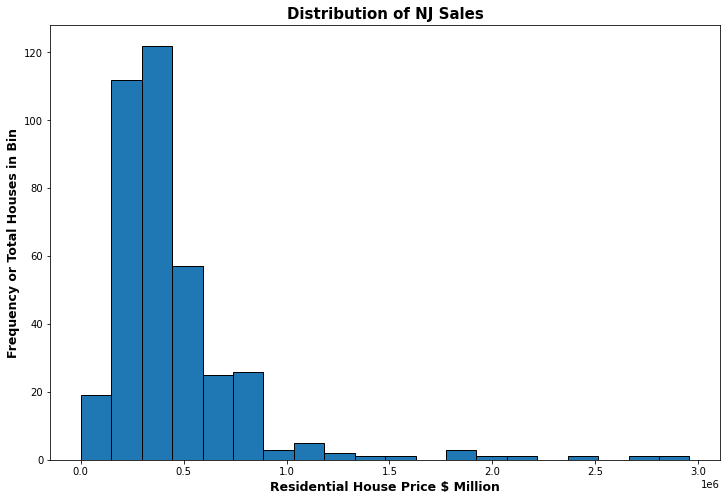

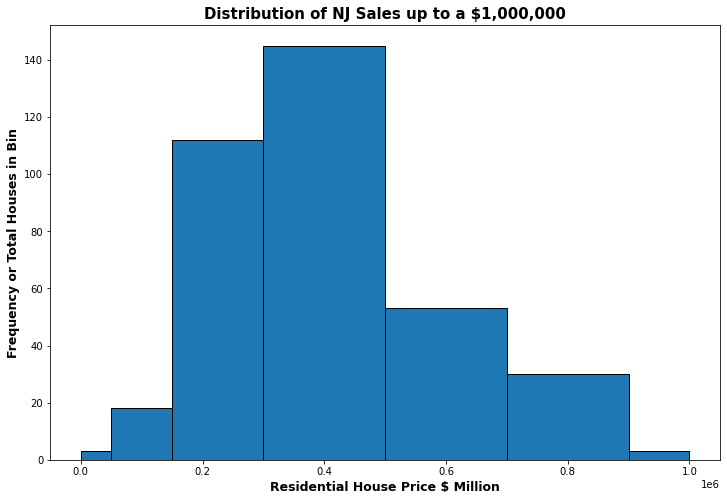

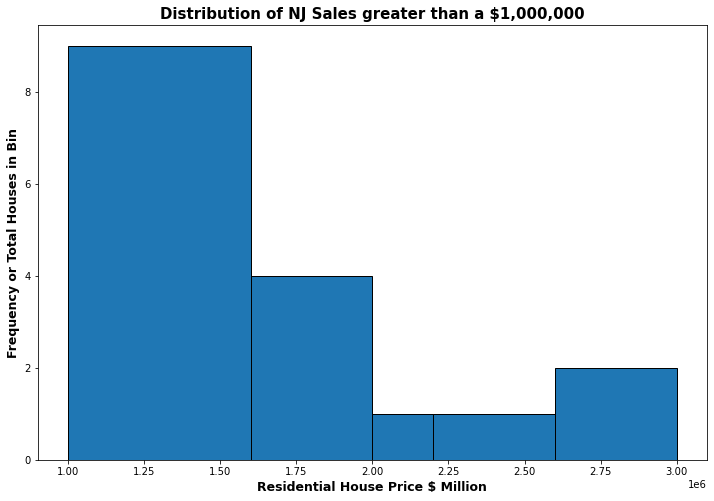

-----------------------------
Distribution of all NJ Sales
-----------------------------
count    3.810000e+02
mean     4.432320e+05
std      3.504435e+05
min      0.000000e+00
25%      2.532877e+05
50%      3.664606e+05
75%      5.142902e+05
max      2.958280e+06
Name: Avg Sale Price, dtype: float64
------------------------------------------
Distribution of NJ Sales up to a $1,000,000
--------------------------------------------
        # of Sales  Avg Sale Price   Longitude    Latitude       Venue
count   364.000000      364.000000  364.000000  364.000000  364.000000
mean    136.123626   385470.118722  -74.491605   40.442954   75.156593
std     189.674038   191463.749867    0.383027    0.513680   39.308348
min       0.000000        0.000000  -75.519230   38.963652    4.000000
25%      32.750000   246600.822025  -74.808635   40.002275   45.000000
50%      76.500000   352419.658650  -74.417222   40.620219   86.000000
75%     160.000000   480482.084825  -74.155975   40.856908  100.00000

In [33]:
Prices = newnew_df["Avg Sale Price"]
Prices
plt.figure(figsize = (12,8))
plt.hist(Prices, bins = 20, edgecolor = 'black')
plt.title("Distribution of NJ Sales",fontsize = 15,fontweight = 'bold')
plt.xlabel('Residential House Price $ Million',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Frequency or Total Houses in Bin',fontsize = 12.5,fontweight = 'bold')
plt.show()

bins = [0,50000,150000,300000,500000,700000,900000,999999]
plt.figure(figsize = (12,8))
plt.hist(Prices, bins = bins, edgecolor = 'black')
plt.title("Distribution of NJ Sales up to a $1,000,000",fontsize = 15,fontweight = 'bold')
plt.xlabel('Residential House Price $ Million',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Frequency or Total Houses in Bin',fontsize = 12.5,fontweight = 'bold')

plt.show()

bins = [1000000,1600000,2000000,2200000,2600000,3000000]
plt.figure(figsize = (12,8))
plt.hist(Prices, bins = bins, edgecolor = 'black')
plt.title("Distribution of NJ Sales greater than a $1,000,000",fontsize = 15,fontweight = 'bold')
plt.xlabel('Residential House Price $ Million',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Frequency or Total Houses in Bin',fontsize = 12.5,fontweight = 'bold')

plt.show()

Prices_ = newnew_df[newnew_df["Avg Sale Price"] < 999999]
Prices__ = newnew_df[newnew_df["Avg Sale Price"] > 1000000]
print('-----------------------------')
print("Distribution of all NJ Sales")
print('-----------------------------')
print(Prices.describe())
print('------------------------------------------')
print("Distribution of NJ Sales up to a $1,000,000")
print('--------------------------------------------')
print(Prices_.describe())
print('-------------------------------------------------')
print("Distribution of NJ Sales greater than $1,000,000")
print('------------------------------------------------')
print(Prices__.describe())


### b. 30 most expensive towns in NJ

In [34]:
Exp_town = new_df[['Cleaned City','Avg Sale Price', 'Latitude', 'Longitude']]
Exp_town.sort_values(by = 'Avg Sale Price', ascending = False, inplace = True)
Exp_town.head(30)


<ipython-input-34-302bad7a2c9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Exp_town.sort_values(by = 'Avg Sale Price', ascending = False, inplace = True)


,Cleaned City,Avg Sale Price,Latitude,Longitude
304,Mantoloking,2.958280e+06,40.025258,-74.055790
224,Allenhurst,2.733333e+06,40.302718,-74.249280
16,Alpine,2.469375e+06,40.952814,-73.930640
259,Sea Girt,2.162083e+06,40.133754,-74.041230
65,Saddle River,1.986882e+06,41.054568,-74.096160
262,Spring Lake,1.903190e+06,40.153024,-74.033720
258,Rumson,1.830917e+06,40.369145,-73.995760
120,Avalon,1.788846e+06,39.092928,-74.726880
124,Stone Harbor,1.523616e+06,39.051289,-74.762040
30,Englewood Cliffs,1.337534e+06,40.883749,-73.951730


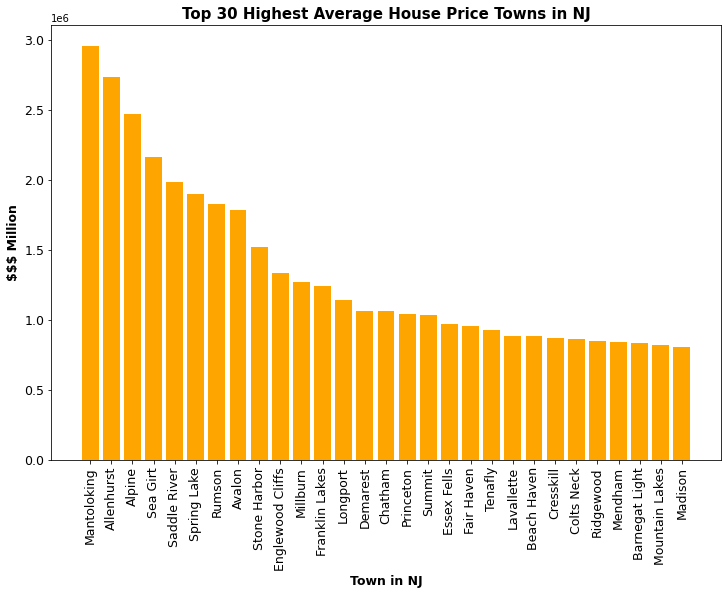

In [35]:
x=[]
for City in Exp_town['Cleaned City']:
    x.append(City)
X = x[:30]    
Y = Exp_town['Avg Sale Price'][:30]
plt.figure(figsize = (12,8))
plt.bar(X,Y, color = 'orange')
plt.xlabel('Town in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('$$$ Million',fontsize = 12.5,fontweight = 'bold')
plt.title("Top 30 Highest Average House Price Towns in NJ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(Exp_town['Latitude'][:30], Exp_town['Longitude'][:30], Exp_town['Cleaned City'][:30],
                                 Exp_town['Avg Sale Price'][:30]):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ    

### c. 30 most cheapest towns in NJ

In [36]:
cheap_town = new_df[['Cleaned City','Avg Sale Price', 'Latitude', 'Longitude']]
cheap_town.sort_values(by = 'Avg Sale Price', ascending = True, inplace = True)

cheap_town.head(25)

<ipython-input-36-07b942edc5ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cheap_town.sort_values(by = 'Avg Sale Price', ascending = True, inplace = True)


,Cleaned City,Avg Sale Price,Latitude,Longitude
69,Teterboro,0.0000,40.853723,-74.059870
232,Deal,0.0000,40.250104,-74.001530
341,Andover,0.0000,40.966308,-74.742980
328,Salem,68508.5714,39.549912,-75.439430
102,Camden,74312.2152,39.918663,-75.109760
199,Trenton,77027.9263,40.172960,-74.669150
325,Penns Grove,83000.0000,39.712593,-75.469060
127,Bridgeton,94425.1719,39.445164,-75.242150
162,Paulsboro,108168.3778,39.833156,-75.237730
1,Atlantic City,117895.3232,39.509208,-74.608557


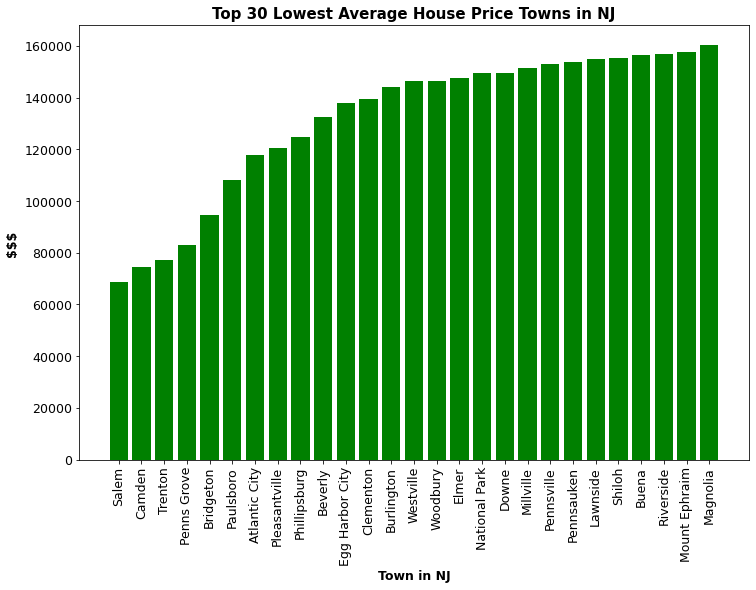

In [37]:
x=[]
for City in cheap_town['Cleaned City']:
    x.append(City)
X = x[3:30]    
Y = cheap_town['Avg Sale Price'][3:30]
plt.figure(figsize = (12,8))
plt.bar(X,Y, color = 'green')
plt.xlabel('Town in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('$$$ ',fontsize = 12.5,fontweight = 'bold')
plt.title("Top 30 Lowest Average House Price Towns in NJ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(cheap_town['Latitude'][3:30], cheap_town['Longitude'][3:30], cheap_town['Cleaned City'][3:30],
                                 cheap_town['Avg Sale Price'][3:30]):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ    

### d. Rank counties from cheapest to least

In [38]:
county_group = new_df.groupby(by = ['County']).sum()
county_group.sort_values(by = 'Avg Sale Price', ascending = False, inplace = True)
#county_group.to_csv("countygroup.csv")

county_group = pd.read_csv("countygroup.csv")
county_group



,County,# of Sales,Avg Sale Price,Longitude,Latitude
0,Bergen,5321.0,3.689383e+07,-4517.117576,2496.386863
1,Monmouth,2420.0,2.502213e+07,-2817.837853,1531.186661
2,Morris,2964.0,1.502996e+07,-2159.988379,1184.997458
3,Ocean,6363.0,9.952413e+06,-1335.152654,718.546485
4,Union,4242.0,9.336689e+06,-1486.425280,813.244548
5,Essex,3380.0,9.218609e+06,-1262.074910,693.505203
6,Middlesex,5080.0,8.089941e+06,-1711.215036,930.947296
7,Somerset,649.0,6.357036e+06,-969.684645,527.722662
8,Hunterdon,967.0,6.314968e+06,-1348.544221,730.890530
9,CapeMay,1651.0,5.870034e+06,-523.324828,273.796615


(array([       0.,  5000000., 10000000., 15000000., 20000000., 25000000.,
        30000000., 35000000., 40000000.]),
 <a list of 9 Text major ticklabel objects>)

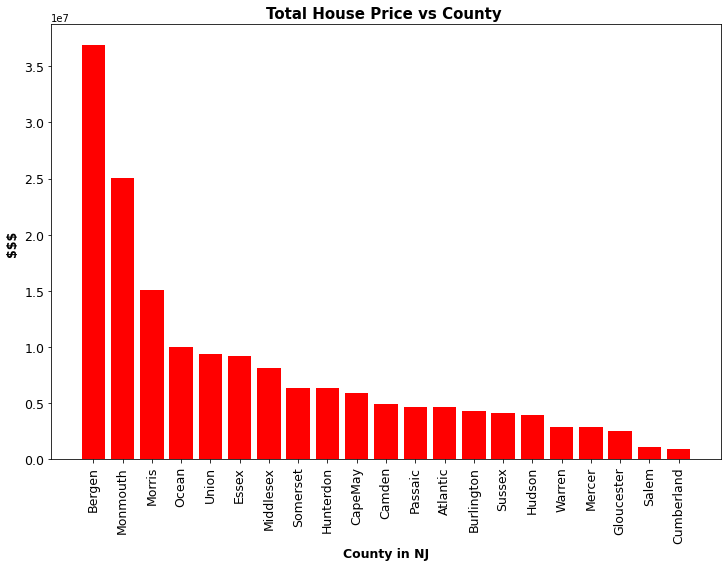

In [39]:
# Plot


x = []
for County in county_group['County']:
    x.append(County)
    
plt.figure(figsize = (12,8))   
plt.bar(x, county_group['Avg Sale Price'],color = "red")
plt.xlabel('County in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('$$$ ',fontsize = 12.5,fontweight = 'bold')
plt.title("Total House Price vs County ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)


    

In [40]:
NJ_County


,County,FIPS Code,Density,Population,Area,AreaClean
1,Atlantic,001,489.39,263670.0,"561 sq mi(1,453 km2)",561
2,Bergen,003,3868.02,932202.0,234 sq mi(606 km2),234
3,Burlington,005,557.43,445349.0,"805 sq mi(2,085 km2)",805
4,Camden,007,2313.77,506471.0,222 sq mi(575 km2),222
5,CapeMay,009,381.43,92039.0,255 sq mi(660 km2),255
6,Cumberland,011,320.85,149527.0,"489 sq mi(1,267 km2)",489
7,Essex,013,6221.98,798975.0,126 sq mi(326 km2),126
8,Gloucester,015,887.04,291636.0,325 sq mi(842 km2),325
9,Hudson,017,13495.02,672391.0,47 sq mi(122 km2),47
10,Hunterdon,019,298.49,124371.0,"430 sq mi(1,114 km2)",430


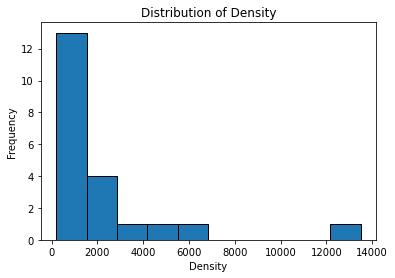

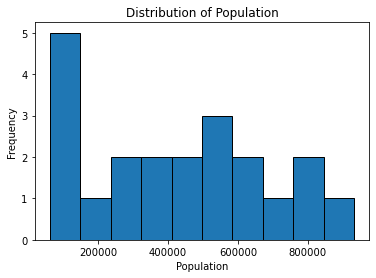

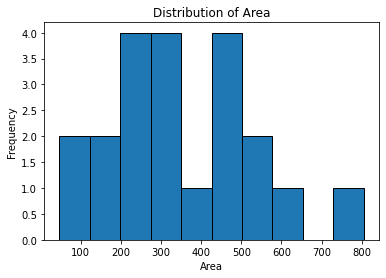

In [41]:
# Distribution

density = NJ_County['Density']
plt.hist(density, edgecolor = 'black')
plt.title("Distribution of Density")
plt.xlabel('Density')
plt.ylabel('Frequency')

plt.show()

population = NJ_County['Population']
plt.hist(population, bins = 10, edgecolor = 'black')
plt.title("Distribution of Population")
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()

population = NJ_County['AreaClean']
plt.hist(population,bins = 10, edgecolor = 'black')
plt.title("Distribution of Area")
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

### Density vs County Plot

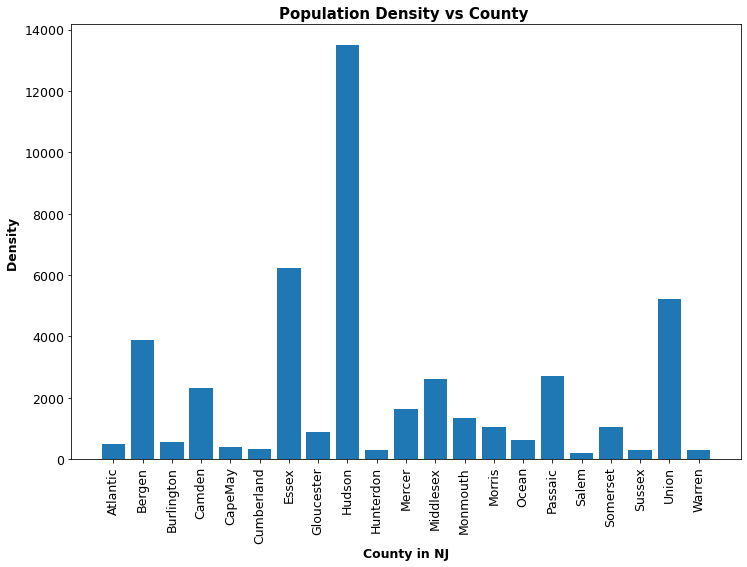

In [42]:
x=[]
for County in NJ_County['County']:
    x.append(County)

plt.figure(figsize = (12,8))   
plt.bar(x, NJ_County['Density'].replace(',','',regex = True).astype('float'))
plt.xlabel('County in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Density ',fontsize = 12.5,fontweight = 'bold')
plt.title("Population Density vs County ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

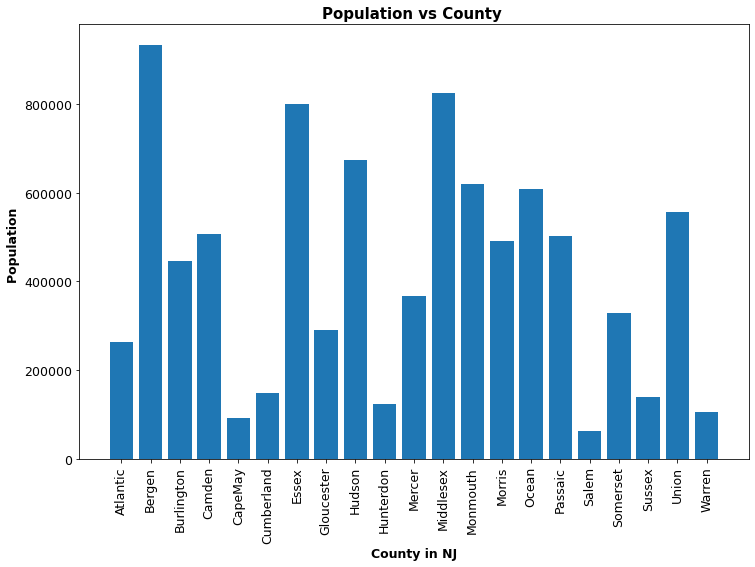

In [43]:
x=[]
for County in NJ_County['County']:
    x.append(County)

plt.figure(figsize = (12,8))   
plt.bar(x, NJ_County['Population'])
plt.xlabel('County in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Population ',fontsize = 12.5,fontweight = 'bold')
plt.title("Population vs County ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

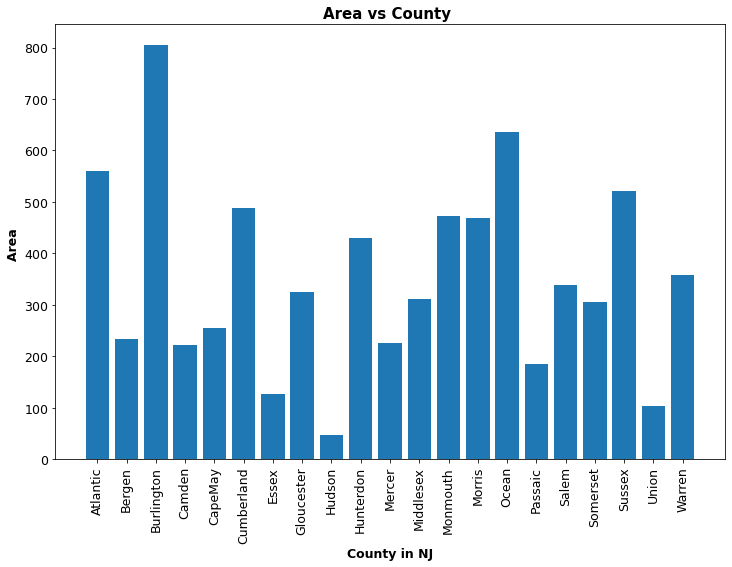

In [44]:
x=[]
for County in NJ_County['County']:
    x.append(County)

plt.figure(figsize = (12,8))   
plt.bar(x, NJ_County['AreaClean'])
plt.xlabel('County in NJ',fontsize = 12.5,fontweight = 'bold')
plt.ylabel('Area ',fontsize = 12.5,fontweight = 'bold')
plt.title("Area vs County ", fontsize = 15, fontweight = 'bold')
plt.xticks(rotation = 90, fontsize = 12.5)
plt.yticks(fontsize = 12.5)
plt.show()

In [45]:
# k.  towns with the most amount of things to do in  a 5 miles radius
# l. top 25 towns with < 75 venues
# m. top 25 towns with < 20 venues
# i. plot venues by county find relation

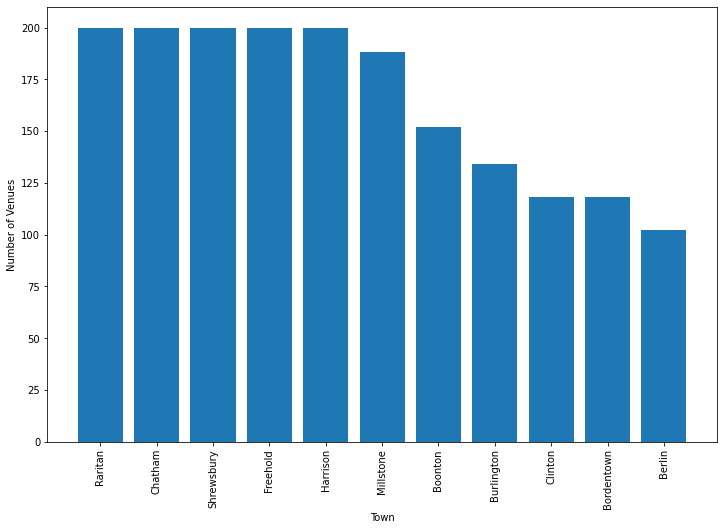

In [46]:
dfgt75  = newnew_df[newnew_df['Venue'] > 100].sort_values(by = 'Venue', ascending = False)
dfgt75

x=[]
for city in dfgt75['Cleaned City']:
    x.append(city)
y = dfgt75['Venue']

plt.figure(figsize = (12,8))
plt.bar(x[:51],y[:51])
plt.xlabel("Town")
plt.ylabel("Number of Venues")
plt.xticks(rotation = 90)
plt.show()

# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(dfgt75['Latitude'][:51], dfgt75['Longitude'][:51], dfgt75['Cleaned City'][:51],
                                 dfgt75['Avg Sale Price'][:51]):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ   

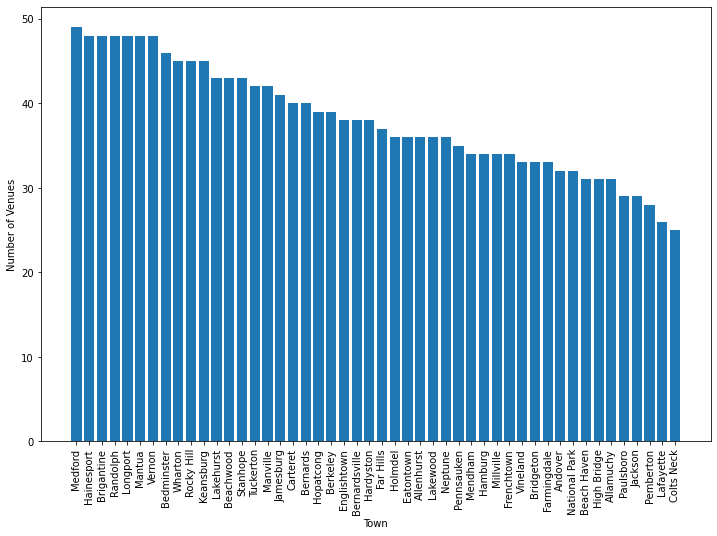

In [47]:
dflt75  = newnew_df[newnew_df['Venue'] < 50].sort_values(by = 'Venue', ascending = False)
dflt75

x=[]
for city in dflt75['Cleaned City']:
    x.append(city)
y = dflt75['Venue']

plt.figure(figsize = (12,8))
plt.bar(x[:51],y[:51])
plt.xlabel("Town")
plt.ylabel("Number of Venues")
plt.xticks(rotation = 90)
plt.show()

# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(dflt75['Latitude'][:51], dflt75['Longitude'][:51], dflt75['Cleaned City'][:51],
                                 dflt75['Avg Sale Price'][:51]):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ 

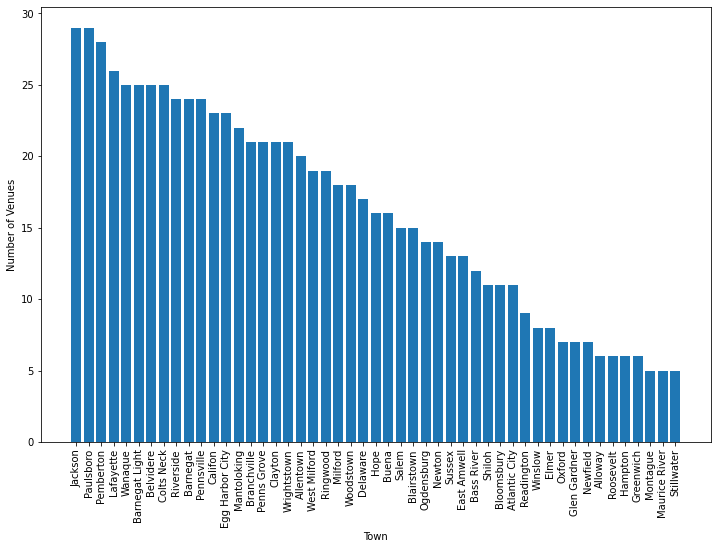

In [48]:
dfgt75  = newnew_df[newnew_df['Venue'] < 30].sort_values(by = 'Venue', ascending = False)
dfgt75

x=[]
for city in dfgt75['Cleaned City']:
    x.append(city)
y = dfgt75['Venue']

plt.figure(figsize = (12,8))
plt.bar(x[:51],y[:51])
plt.xlabel("Town")
plt.ylabel("Number of Venues")
plt.xticks(rotation = 90)
plt.show()

# creating map of NJ using latitude and longitude values
map_NJ = folium.Map(location=[40.138783, -74.67691], zoom_start=8)
# add markers to map
for lat, lng, City, Price  in zip(dfgt75['Latitude'][:51], dfgt75['Longitude'][:51], dfgt75['Cleaned City'][:51],
                                 dfgt75['Avg Sale Price'][:51]):
    label = '{}, {}'.format(City, Price )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        #fill=True,
        #fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NJ)   
map_NJ 

### 

6187.325323900795 -436909.43363662803


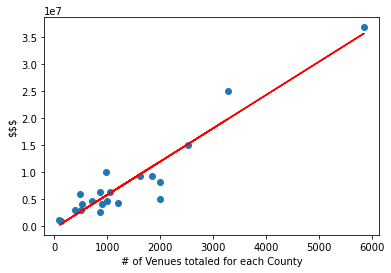

The R^2 is 0.8996722578529943


In [49]:

dec_df = newnew_df[['Cleaned City','Avg Sale Price', 'Venue','County']]
a=dec_df.groupby(by = ['County']).sum()
a.to_csv('CountyVPV.csv')
CountyVPV = pd.read_csv('CountyVPV.csv')

Y = CountyVPV['Avg Sale Price']
X = CountyVPV['Venue']


plt.scatter(X,Y)
plt.xlabel('# of Venues totaled for each County')
plt.ylabel('$$$')

m, b = np.polyfit(X, Y, 1)
print(m,b)

plt.plot(X, m*X + b, color = "red")

plt.show()
def get_r2_numpy_corrcoef(x, y):
    return np.corrcoef(x, y)[0, 1]**2

print("The R^2 is " + str(get_r2_numpy_corrcoef(X,Y)))

In [50]:
dec_df

,Cleaned City,Avg Sale Price,Venue,County
0,Absecon,186314.0374,71,Atlantic
1,Atlantic City,117895.3232,11,Atlantic
2,Brigantine,366460.6029,48,Atlantic
3,Buena,156327.0952,16,Atlantic
4,Egg Harbor City,137736.2500,23,Atlantic
...,...,...,...,...
376,Blairstown,326982.7705,15,Warren
377,Hackettstown,289336.2500,59,Warren
378,Hope,312111.9048,16,Warren
379,Oxford,203851.5152,7,Warren


### Cluster A Opt

In [51]:
df_a1 = df_a[['Cleaned City','Avg Sale Price','Venue',"County"]]
A = df_a1.sort_values(by = 'Avg Sale Price', ascending = True)
df_a2 = df_a1[df_a1['Venue'] > 75]
df_a2_rec = df_a2.sort_values(by = 'Avg Sale Price', ascending = True)

print(df_a2.describe())
print('--------------')
print(df_a2)
print('--------------')
df_a2_rec.groupby('County').mean().sort_values(by = 'Avg Sale Price', ascending = True)




       Avg Sale Price       Venue
count       16.000000   16.000000
mean    156924.868956  105.375000
std      26798.470105   27.453901
min      74312.215200   83.000000
25%     152871.849950   96.500000
50%     164231.617650  100.000000
75%     168901.540900  100.000000
max     184802.884600  200.000000
--------------
      Cleaned City  Avg Sale Price  Venue      County
81      Burlington     144096.7653    134  Burlington
86     Maple Shade     168524.4565    100  Burlington
89         Palmyra     165479.6203     95  Burlington
99        Bellmawr     168120.3667     83      Camden
102         Camden      74312.2152     85      Camden
109       Lawnside     155007.6923     92      Camden
110       Magnolia     160177.2727    100      Camden
112  Mount Ephraim     157788.0328    100      Camden
113         Oaklyn     184802.8846    100      Camden
115      Runnemede     170032.7941     97      Camden
116      Somerdale     163463.2353    100      Camden
117      Stratford     178485.9

,Avg Sale Price,Venue
County,,
Warren,124587.318200,100.000000
Gloucester,146464.322900,100.000000
Camden,156910.045600,95.222222
Burlington,159366.947367,109.666667
Monmouth,165000.000000,200.000000
Essex,184455.009700,100.000000


### Cluster B Opt

In [52]:
df_b1 = df_b[['Cleaned City','Avg Sale Price','Venue',"County"]]
B = df_b1.sort_values(by = 'Avg Sale Price', ascending = True)
df_b2 = df_b1[df_b1['Venue'] > 75]
df_b2_rec = df_b2.sort_values(by = 'Avg Sale Price', ascending = True)

print(df_b2.describe())
print('--------------')
print(df_b2)
print('--------------')
df_b2_rec.groupby('County').mean().sort_values(by = 'Avg Sale Price', ascending = True)



       Avg Sale Price       Venue
count       81.000000   81.000000
mean    314500.132669  102.370370
std      56412.049334   23.321366
min     200272.368400   76.000000
25%     277240.000000  100.000000
50%     321448.275900  100.000000
75%     354441.818200  100.000000
max     399770.636400  200.000000
--------------
        Cleaned City  Avg Sale Price  Venue    County
10        Northfield     215845.0179     90  Atlantic
13      Somers Point     227182.0759     81  Atlantic
18            Bogota     375388.2353    100    Bergen
25      Elmwood Park     354441.8182    100    Bergen
26   East Rutherford     388250.0000    100    Bergen
..               ...             ...    ...       ...
364           Linden     321751.7944    100     Union
367       Plainfield     298380.3061     92     Union
368           Rahway     292212.8372    100     Union
369          Roselle     266035.3500    100     Union
370     Roselle Park     305487.1261    100     Union

[81 rows x 4 columns]
--------

,Avg Sale Price,Venue
County,,
Atlantic,221513.546900,85.500000
Sussex,224871.934800,100.000000
CapeMay,236821.333300,100.000000
Mercer,242469.525000,91.000000
Camden,246265.039278,96.000000
Gloucester,257252.875933,117.666667
Burlington,280310.002850,126.000000
Essex,301801.893920,100.000000
Union,316083.200111,99.111111


In [53]:
df_c1 = df_c[['Cleaned City','Avg Sale Price','Venue',"County"]]
C = df_c1.sort_values(by = 'Avg Sale Price', ascending = True)
df_c2 = df_c1[df_c1['Venue'] > 75]
df_c2_rec = df_c2.sort_values(by = 'Avg Sale Price', ascending = True)

print(df_c2.describe())
print('--------------')
print(df_c2)
print('--------------')
df_c2_rec.groupby('County').mean().sort_values(by = 'Avg Sale Price', ascending = True)



       Avg Sale Price       Venue
count       71.000000   71.000000
mean    473477.173935  104.140845
std      52856.837963   25.431306
min     402051.282100   77.000000
25%     426754.537250   96.500000
50%     464766.397000  100.000000
75%     511490.719000  100.000000
max     588843.757000  200.000000
--------------
       Cleaned City  Avg Sale Price  Venue  County
17      Bergenfield     417595.4444    100  Bergen
19        Carlstadt     433240.0000    100  Bergen
20   Cliffside Park     479492.7012    100  Bergen
24           Dumont     416009.5584    100  Bergen
28          Emerson     500459.3750    100  Bergen
..              ...             ...    ...     ...
357           Clark     455331.1000     89   Union
358        Cranford     497696.7978    100   Union
360         Fanwood     490089.7073    100   Union
361         Garwood     428888.1875    100   Union
371   Scotch Plains     530904.2702    100   Union

[71 rows x 4 columns]
--------------


,Avg Sale Price,Venue
County,,
Hunterdon,422045.952950,159.000000
Passaic,442781.825750,97.000000
Somerset,447745.312500,86.000000
Bergen,462721.006048,97.655172
Hudson,464103.134067,115.333333
Middlesex,470645.919700,100.000000
Union,473617.524917,98.166667
Morris,486824.511614,110.285714
Ocean,487820.065800,88.500000


In [54]:
df_d1 = df_d[['Cleaned City','Avg Sale Price','Venue',"County"]]
D = df_d1.sort_values(by = 'Avg Sale Price', ascending = True)
df_d2 = df_d1[df_d1['Venue'] > 75]
df_d2_rec = df_d2.sort_values(by = 'Avg Sale Price', ascending = True)

print(df_d2.describe())
print('--------------')
print(df_d2)
print('--------------')
df_d2_rec.groupby('County').mean().sort_values(by = 'Avg Sale Price', ascending = True)



       Avg Sale Price      Venue
count       30.000000   30.00000
mean    712002.585457  103.10000
std      69921.867963   27.16533
min     600201.289200   79.00000
25%     648037.561925   97.50000
50%     710239.929150  100.00000
75%     765017.113600  100.00000
max     822828.642900  200.00000
--------------
        Cleaned City  Avg Sale Price  Venue     County
15         Allendale     767248.4848    100     Bergen
27         Edgewater     600201.2892    100     Bergen
35         Glen Rock     659864.2478    100     Bergen
37   Harrington Park     675482.3659    100     Bergen
38           Haworth     702390.3846    100     Bergen
47          Montvale     644095.3333    100     Bergen
52           Norwood     626394.5179     97     Bergen
55    Palisades Park     718089.4737    100     Bergen
56           Paramus     740036.2069    100     Bergen
75    Woodcliff Lake     694312.5000     99     Bergen
121         Cape May     741125.1462     84    CapeMay
122       Ocean City     634

,Avg Sale Price,Venue
County,,
Monmouth,682523.237967,114.5
Bergen,682811.480410,99.6
Somerset,685200.000000,80.0
CapeMay,687965.152700,92.0
Union,713750.131750,82.0
Essex,748044.735350,100.0
Middlesex,758323.000000,100.0
Morris,777310.255680,116.4
Hudson,807229.013800,100.0


In [55]:
df_e1 = df_e[['Cleaned City','Avg Sale Price','Venue',"County"]]
E = df_e1.sort_values(by = 'Avg Sale Price', ascending = True)
df_e2 = df_e1[df_e1['Venue'] > 75]
df_e2_rec = df_e2.sort_values(by = 'Avg Sale Price', ascending = True)

print(df_a2.describe())
print('--------------')
print(df_e2)
print('--------------')
df_e2_rec.groupby('County').mean().sort_values(by = 'Avg Sale Price', ascending = True)


       Avg Sale Price       Venue
count       16.000000   16.000000
mean    156924.868956  105.375000
std      26798.470105   27.453901
min      74312.215200   83.000000
25%     152871.849950   96.500000
50%     164231.617650  100.000000
75%     168901.540900  100.000000
max     184802.884600  200.000000
--------------
         Cleaned City  Avg Sale Price  Venue    County
16             Alpine    2.469375e+06     83    Bergen
22          Cresskill    8.690314e+05    100    Bergen
23           Demarest    1.064515e+06     97    Bergen
30   Englewood Cliffs    1.337534e+06    100    Bergen
61          Ridgewood    8.522472e+05    100    Bergen
65       Saddle River    1.986882e+06     91    Bergen
68            Tenafly    9.306590e+05    100    Bergen
69          Teterboro    0.000000e+00    100    Bergen
124      Stone Harbor    1.523616e+06     77   CapeMay
141       Essex Fells    9.731500e+05    100     Essex
146          Millburn    1.268455e+06    100     Essex
200         Princet

,Avg Sale Price,Venue
County,,
Union,1.038972e+06,100.000
Mercer,1.039751e+06,82.000
Morris,1.063323e+06,200.000
Essex,1.120802e+06,100.000
Bergen,1.188781e+06,96.375
Monmouth,1.355091e+06,92.000
CapeMay,1.523616e+06,77.000


In [56]:
# my function
def split_compass(Town):
    if Town[0:4] == 'East':
        return Town.split(' ')[1]
    elif Town[0:4] == 'West':
        return Town.split(' ')[1]
    elif Town[0:5] == 'North':
        return Town.split(' ')[1]
    elif Town[0:5] == 'South':
        return Town.split(' ')[1]
    else:
        return Town    
# same function as above but more succint     
def split_compass1(town):
    words = town.split(' ')
    if words[0] in ['East', 'West','North', 'South']:
        words = words[1:]
    return ' '.join(words) 

#NJ_Price["Cleaned City"] = NJ_Price['CITY'].apply(lambda x: split_compass1(x))

#NJ_Price.head(50)

